# Анализ прибыльности авиарейсов<br />(г. Анапа, зима 2016-2017)
## Власов Д. В. (группа dst-26)

## Загрузка библиотек для работы с данными

In [1]:
!pip install haversine

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import iqr

import datetime as dt

from haversine import haversine, Unit

### Настройка библиотек

In [3]:
pd.set_option('display.encoding', "UTF-8")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# pd.set_option('display.html.border', 2)
# pd.set_option('display.html.table_schema', True)

### Оформление

In [4]:
# from IPython.core.display import display, HTML


# def css_border(x):
#     return ["border-left: 2px solid black" if (i % 2 == 0) else "border-left: 2px solid black" for i, col in enumerate(x)]


# def pd_html(df: pd.DataFrame):
#     return HTML(( df.style.apply(css_border, axis=1).render() ))


# def display_pd_html(df: pd.DataFrame):
#     return display(pd_html(df))

## Подпрограммы работы с данными

### Подпрограммы для графического отображения данных

In [5]:
def get_boxplot(data: pd.DataFrame, column_x, column_y):
    """Рисование диаграммы boxplot для
    колонки column_x по оси абсцисс и колонки column_y по оси ординат.

    Parameters:
        data - общий набор данных, в колонке column которого найдены выбросы
        column_x - колонка с данными, откладываемыми по оси абсцисс
        column_y - колонка с данными, откладываемыми по оси ординат
    
    Returns:
        See description.
    """
    fig, ax = plt.subplots(figsize = (14, 4))

    column_x_values = list(data[column_x].unique())
    column_x_values.sort()
    sns.boxplot(
        x=column_x, y=column_y.name, 
        data=data,
        ax=ax,
        order=column_x_values)

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column_x)
    plt.show()

## 1. Загрузка сырых данных

### 1.1 Загрузка данных о перелётах из Анапы в зимние месяцы 2017-го года

In [6]:
data_raw = pd.read_csv('initial_raw_dataset_2016_2017.csv')

In [7]:
data_raw.sample(5)

,flight_id,departure_airport,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,tickets_all,seats,total_load,amount_economy,amount_business,amount_all,aircraft_code,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
10,136540,AAQ,NOZ,2017-01-17T06:14:00Z,2017-01-17T11:21:00Z,4.0,6.0,0,118,0.000000,0,12,0.000000,0,130,0.000000,0.0,0.0,0.0,733,4200,45.002102,37.347301,53.811401,86.877197
3,136511,AAQ,NOZ,2017-02-21T06:15:00Z,2017-02-21T11:25:00Z,5.0,10.0,0,118,0.000000,0,12,0.000000,0,130,0.000000,0.0,0.0,0.0,733,4200,45.002102,37.347301,53.811401,86.877197
180,136600,AAQ,EGO,2017-02-08T09:26:00Z,2017-02-08T10:16:00Z,1.0,1.0,85,85,1.000000,12,12,1.000000,97,97,1.000000,538500.0,226800.0,765300.0,SU9,3000,45.002102,37.347301,50.643799,36.590099
73,136257,AAQ,SVO,2016-12-18T10:09:00Z,2016-12-18T11:49:00Z,4.0,4.0,100,118,0.847458,11,12,0.916667,111,130,0.853846,1226000.0,402600.0,1628600.0,733,4200,45.002102,37.347301,55.972599,37.414600
63,136936,AAQ,EGO,2017-01-02T09:28:00Z,2017-01-02T10:18:00Z,3.0,3.0,73,85,0.858824,9,12,0.750000,82,97,0.845361,462300.0,170100.0,632400.0,SU9,3000,45.002102,37.347301,50.643799,36.590099


### 1.2 Загрузка дополнительных данных по моделям самолётов

In [8]:
data_aircraft = pd.read_csv('aircraft-data.csv')

In [9]:
data_aircraft.sample(2)

,aircraft_id,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L
0,1,733,Boeing 737-300,25.00,2400,23830
1,2,SU9,Sukhoi Superjet-100,23.46,1800,15805


### 1.3 Загрузка цен для аэропортов<br />(цена на топливо, цена простоя за минуту,..)

<b>Замечание:</b><br />
Цена задержки за минуту рейса при вылете или прилёте судна ($38 - для Boeing 737-800)<br />
взята ориентировочно на основе оценки:<br />
[How much does it cost the airliner per minute when a plane is delayed?](https://www.quora.com/How-much-does-it-cost-the-airliner-per-minute-when-a-plane-is-delayed "How much does it cost the airliner per minute when a plane is delayed?")<br />
Курс доллара США взят примерно равным 60 рублям за 1 доллар для 2017-го года.

<div style="color: gray">
Другой вариант: https://www.airlines.org/dataset/per-minute-cost-of-delays-to-u-s-airlines/# .<br />
</div>

In [10]:
data_airport = pd.read_csv('airport-prices.csv')

In [11]:
data_airport.head(3)

,year_month,airport_code,fuel_price_rubles_per_ton,fuel_value_added_tax,delay_cost_per_minute
0,2017-01,AAQ,41435,0.18,2280
1,2017-02,AAQ,39553,0.18,2280
2,2017-12,AAQ,47101,0.18,2280


In [12]:
data_airport["year_month"] = pd.to_datetime(data_airport["year_month"], format="%Y-%m")

In [13]:
data_airport.head(16)

,year_month,airport_code,fuel_price_rubles_per_ton,fuel_value_added_tax,delay_cost_per_minute
0,2017-01-01,AAQ,41435,0.18,2280
1,2017-02-01,AAQ,39553,0.18,2280
2,2017-12-01,AAQ,47101,0.18,2280
3,2016-12-01,AAQ,38867,0.18,2280
4,2017-01-01,EGO,36864,0.18,2280
5,2017-02-01,EGO,36864,0.18,2280
6,2017-12-01,EGO,44068,0.18,2280
7,2016-12-01,EGO,34746,0.18,2280
8,2017-01-01,SVO,36853,0.18,2280
9,2017-02-01,SVO,36853,0.18,2280


In [14]:
# data_airport.loc[data_airport.loc[:, "fuel_price_rubles_per_ton"].isin(data_airport.loc[:, "fuel_price_rubles_per_ton"].value_counts().index[:5])]

## 2. Добавление дополнительных данных к каждому рейсу

### 2.1 Предобработка колонок с датами и временем вылета/прилёта

In [15]:
data_raw["actual_departure"] = pd.to_datetime(data_raw["actual_departure"], format="%Y-%m-%dT%H:%M:%SZ")
data_raw["actual_arrival"] = pd.to_datetime(data_raw["actual_arrival"], format="%Y-%m-%dT%H:%M:%SZ")

### 2.2 Добавление колонок<br /><i>удельного расхода топлива</i> и<br/><i>часового расхода</i>

In [16]:
data = data_raw.join(data_aircraft.set_index("aircraft_code"), on="aircraft_code")
data.drop(["aircraft_id"], axis=1, inplace=True)
data = data.reindex(
    columns=[
        "flight_id", "departure_airport", "arrival_airport",
        "actual_departure", "actual_arrival", "departure_delay_mins", "arrival_delay_mins",
        "tickets_all", "seats", "total_load", "amount_all",
        "tickets_economy", "seats_economy", "economy_load",
        "tickets_business", "seats_business", "business_load",
        "amount_economy", "amount_business",
        "aircraft_code", "aircraft_name",
        "fuel_g_per_pass_km", "fuel_kg_per_hour", "fuel_tank_volume_L",
        "range",
        "departure_airport_latitude", "departure_airport_longitude",
        "arrival_airport_latitude", "arrival_airport_longitude"
    ]
)

In [17]:
data.sample(5)

,flight_id,departure_airport,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
8,136533,AAQ,NOZ,2016-12-13 06:13:00,2016-12-13 11:16:00,3.0,1.0,0,130,0.000000,0.0,0,118,0.000000,0,12,0.000000,0.0,0.0,733,Boeing 737-300,25.00,2400,23830,4200,45.002102,37.347301,53.811401,86.877197
173,136872,AAQ,EGO,2016-12-14 09:26:00,2016-12-14 10:16:00,1.0,1.0,97,97,1.000000,765300.0,85,85,1.000000,12,12,1.000000,538500.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,3000,45.002102,37.347301,50.643799,36.590099
37,136351,AAQ,SVO,2017-02-26 10:13:00,2017-02-26 11:53:00,8.0,8.0,105,130,0.807692,1555400.0,94,118,0.796610,11,12,0.916667,1152800.0,402600.0,733,Boeing 737-300,25.00,2400,23830,4200,45.002102,37.347301,55.972599,37.414600
161,136187,AAQ,SVO,2016-12-01 10:09:00,2016-12-01 11:49:00,4.0,4.0,129,130,0.992308,1873800.0,117,118,0.991525,12,12,1.000000,1434600.0,439200.0,733,Boeing 737-300,25.00,2400,23830,4200,45.002102,37.347301,55.972599,37.414600
147,136802,AAQ,EGO,2017-02-26 09:32:00,2017-02-26 10:22:00,7.0,7.0,96,97,0.989691,746400.0,85,85,1.000000,11,12,0.916667,538500.0,207900.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,3000,45.002102,37.347301,50.643799,36.590099


### 2.3 Добавление цен в аэропортах в общую таблицу

In [18]:
# Цена топлива за тонну
data.insert(
    data.columns.get_loc("departure_airport_latitude") - 1, "departure_fuel_price_per_ton", np.nan
)
data.insert(
    data.columns.get_loc("departure_fuel_price_per_ton") + 1, "arrival_fuel_price_per_ton", np.nan
)
# НДС (до 2019-го года НДС был 18%)
data.insert(
    data.columns.get_loc("arrival_fuel_price_per_ton") + 1, "fuel_value_added_tax", np.nan
)
# Стоимость задержки самолёта для аэропорта в минуту
data.insert(
    data.columns.get_loc("fuel_value_added_tax") + 1, "departure_delay_cost_min", np.nan
)
data.insert(
    data.columns.get_loc("departure_delay_cost_min") + 1, "arrival_delay_cost_min", np.nan
)

In [19]:
def airport_prices(data_row: pd.Series):
    departure_airport_code = data_row["departure_airport"]
    departure_date = data_row["actual_departure"]
    departure_date_year = departure_date.year
    departure_date_month = departure_date.month
    departure_monthly_prices = data_airport[
        (
            data_airport["airport_code"] == departure_airport_code
        ) & (
            (
                data_airport["year_month"].dt.year == departure_date_year
            ) & (
                data_airport["year_month"].dt.month == departure_date_month
            )
        )
    ]

    arrival_airport_code = data_row["arrival_airport"]
    arrival_date = data_row["actual_arrival"]
    arrival_date_year = arrival_date.year
    arrival_date_month = arrival_date.month
    arrival_monthly_prices = data_airport[
        (
            data_airport["airport_code"] == arrival_airport_code
        ) & (
            (
                data_airport["year_month"].dt.year == arrival_date_year
            ) & (
                data_airport["year_month"].dt.month == arrival_date_month
            )
        )
    ]

    data_row["departure_fuel_price_per_ton"] = \
        departure_monthly_prices["fuel_price_rubles_per_ton"].iloc[0]
    data_row["arrival_fuel_price_per_ton"] = \
        arrival_monthly_prices["fuel_price_rubles_per_ton"].iloc[0]

    # НДС одинаковый по стране
    data_row["fuel_value_added_tax"] = \
        departure_monthly_prices["fuel_value_added_tax"].iloc[0]

    data_row["departure_delay_cost_min"] = \
        departure_monthly_prices["delay_cost_per_minute"].iloc[0]
    data_row["arrival_delay_cost_min"] = \
        arrival_monthly_prices["delay_cost_per_minute"].iloc[0]
    
    return data_row

airport_columns = [
    "departure_airport", "arrival_airport",
    "actual_departure", "actual_arrival",
    "departure_fuel_price_per_ton", "arrival_fuel_price_per_ton",
    "fuel_value_added_tax",
    "departure_delay_cost_min", "arrival_delay_cost_min"
]
data[airport_columns] = data[airport_columns].apply(airport_prices, axis=1)


In [20]:
data.sample(5)

,flight_id,departure_airport,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
172,136871,AAQ,EGO,2017-01-13 09:28:00,2017-01-13 10:18:00,3.0,3.0,97,97,1.000000,765300.0,85,85,1.000000,12,12,1.000000,538500.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,41435,36864,0.18,2280,2280,3000,45.002102,37.347301,50.643799,36.590099
3,136511,AAQ,NOZ,2017-02-21 06:15:00,2017-02-21 11:25:00,5.0,10.0,0,130,0.000000,0.0,0,118,0.000000,0,12,0.000000,0.0,0.0,733,Boeing 737-300,25.00,2400,23830,39553,36000,0.18,2280,2280,4200,45.002102,37.347301,53.811401,86.877197
155,136672,AAQ,EGO,2017-02-03 09:28:00,2017-02-03 10:18:00,3.0,3.0,96,97,0.989691,759000.0,84,85,0.988235,12,12,1.000000,532200.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,39553,36864,0.18,2280,2280,3000,45.002102,37.347301,50.643799,36.590099
53,136266,AAQ,SVO,2017-02-27 10:08:00,2017-02-27 11:48:00,3.0,3.0,108,130,0.830769,1566400.0,98,118,0.830508,10,12,0.833333,1200400.0,366000.0,733,Boeing 737-300,25.00,2400,23830,39553,36853,0.18,2280,2280,4200,45.002102,37.347301,55.972599,37.414600
169,136757,AAQ,EGO,2017-01-27 09:30:00,2017-01-27 10:19:00,5.0,4.0,97,97,1.000000,765300.0,85,85,1.000000,12,12,1.000000,538500.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,41435,36864,0.18,2280,2280,3000,45.002102,37.347301,50.643799,36.590099


### 2.4 Добавление порядкового номера зимнего месяца
1 - декабрь 2016 - Dec<br />
2 - январь 2017 - Jan<br />
3 - февраль 2017 - Feb

In [21]:
data.insert(
    data.columns.get_loc("actual_departure") - 1, "winter_month", np.nan
)

In [22]:
def fill_winter_month(data_row: pd.Series):
    departure = data_row["actual_departure"]
    month = "01-Dec" if departure.month == 12 \
        else "02-Jan" if departure.month == 1 \
            else "03-Feb" if departure.month == 2 \
                else np.nan

    data_row["winter_month"] = month

    return data_row

data_columns = [
    "actual_departure",
    "winter_month"
]
data[data_columns] = data[data_columns].apply(fill_winter_month, axis=1)

In [23]:
data.winter_month[data.winter_month.isna()].shape[0]

0

In [24]:
data.sample(3)

,flight_id,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
8,136533,AAQ,01-Dec,NOZ,2016-12-13 06:13:00,2016-12-13 11:16:00,3.0,1.0,0,130,0.000000,0.0,0,118,0.000000,0,12,0.000000,0.0,0.0,733,Boeing 737-300,25.00,2400,23830,38867,36000,0.18,2280,2280,4200,45.002102,37.347301,53.811401,86.877197
134,136866,AAQ,01-Dec,EGO,2016-12-28 09:28:00,2016-12-28 10:18:00,3.0,3.0,94,97,0.969072,733800.0,83,85,0.976471,11,12,0.916667,525900.0,207900.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,38867,34746,0.18,2280,2280,3000,45.002102,37.347301,50.643799,36.590099
7,136560,AAQ,02-Jan,NOZ,2017-01-24 06:13:00,2017-01-24 11:18:00,3.0,3.0,0,130,0.000000,0.0,0,118,0.000000,0,12,0.000000,0.0,0.0,733,Boeing 737-300,25.00,2400,23830,41435,36000,0.18,2280,2280,4200,45.002102,37.347301,53.811401,86.877197


### 2.5 Добавление порядкового номера дня, начиная с первого дня декабря и заканчивая последним днём февраля

In [25]:
data.insert(
    data.columns.get_loc("winter_month") - 1, "winter_day", np.nan
)

In [26]:
def fill_winter_month(data_row: pd.Series):
    departure = data_row["actual_departure"]

    day_shift = 0 if departure.month == 12 \
        else 31 if departure.month == 1 \
            else 62 if departure.month == 2 \
                else np.nan

    day_number = day_shift + departure.day

    data_row["winter_day"] = day_number

    return data_row

data_columns = [
    "actual_departure",
    "winter_day"
]
data[data_columns] = data[data_columns].apply(fill_winter_month, axis=1)

In [27]:
data.sample(3)

,flight_id,winter_day,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
13,136642,61,AAQ,02-Jan,EGO,2017-01-30 09:28:00,2017-01-30 10:17:00,3.0,2.0,64,97,0.659794,531000.0,54,85,0.635294,10,12,0.833333,342000.0,189000.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,41435,36864,0.18,2280,2280,3000,45.002102,37.347301,50.643799,36.590099
36,136143,14,AAQ,01-Dec,SVO,2016-12-14 10:06:00,2016-12-14 11:46:00,1.0,1.0,105,130,0.807692,1554200.0,94,118,0.796610,11,12,0.916667,1151600.0,402600.0,733,Boeing 737-300,25.00,2400,23830,38867,36853,0.18,2280,2280,4200,45.002102,37.347301,55.972599,37.414600
116,136951,64,AAQ,03-Feb,EGO,2017-02-02 09:28:00,2017-02-02 10:17:00,3.0,2.0,90,97,0.927835,720600.0,78,85,0.917647,12,12,1.000000,493800.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,39553,36864,0.18,2280,2280,3000,45.002102,37.347301,50.643799,36.590099


## 3. Подпрограммы для расчёта затрат на рейс по расходу топлива

### 3.1 Затраченное топливо в тоннах по<br /><i>расходу топлива за час полёта</i> - килограмм / час

In [28]:
def fuel_expenditures_time(departure, arrival, fuel_kg_per_hour):
    flight_timedelta = arrival - departure
    duration_hours = flight_timedelta.total_seconds() / 3600

    fuel_consumed_ton = (duration_hours * fuel_kg_per_hour) / 1000

    return fuel_consumed_ton

In [29]:
data[data.flight_id == 136270]

,flight_id,winter_day,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
72,136270,74,AAQ,03-Feb,SVO,2017-02-12 10:12:00,2017-02-12 11:51:00,7.0,6.0,111,130,0.853846,1628600.0,100,118,0.847458,11,12,0.916667,1226000.0,402600.0,733,Boeing 737-300,25.0,2400,23830,39553,36853,0.18,2280,2280,4200,45.002102,37.347301,55.972599,37.4146


In [30]:
# Тест для flight_id = 136270
test_departure = dt.datetime(2017, 2, 12, 10, 12, 00)
test_arrival = dt.datetime(2017, 2, 12, 11, 51, 00)
test_fuel_kg_per_hour = 2400
fuel_expenditures_time(test_departure, test_arrival, test_fuel_kg_per_hour)

3.96

### 3.2 Затраченной топливо в тоннах по<br />его <i>удельному расходу</i> - грамм / (пассажир $\cdot$ километр)

In [31]:
def fuel_expenditures_distance(
    departure_coordinates: tuple, arrival_coordinates: tuple,
    passengers: int,
    fuel_g_per_pass_km: float):
    departure_latitude = departure_coordinates[0]
    departure_longitude = departure_coordinates[1]
    arrival_latitude = arrival_coordinates[0]
    arrival_longitude = arrival_coordinates[1]

    distance_kilometers = haversine(
        (departure_latitude, departure_longitude),
        (arrival_latitude, arrival_longitude),
        unit=Unit.KILOMETERS
    )

    fuel_consumed_ton = (fuel_g_per_pass_km * passengers * distance_kilometers) / (1000 * 1000)

    return fuel_consumed_ton

In [32]:
data[data.flight_id == 136270]

,flight_id,winter_day,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
72,136270,74,AAQ,03-Feb,SVO,2017-02-12 10:12:00,2017-02-12 11:51:00,7.0,6.0,111,130,0.853846,1628600.0,100,118,0.847458,11,12,0.916667,1226000.0,402600.0,733,Boeing 737-300,25.0,2400,23830,39553,36853,0.18,2280,2280,4200,45.002102,37.347301,55.972599,37.4146


In [33]:
# Тест для flight_id = 136270
test_departure_coordinates = (45.002102, 37.347301)
test_arrival_coordinates = (55.972599, 37.414600)
# Предположим, что загрузка полная (130 вместо 111):
test_passengers = 130
test_fuel_g_per_pass_km = 25.00
fuel_expenditures_distance(
    test_departure_coordinates,
    test_arrival_coordinates,
    test_passengers,
    test_fuel_g_per_pass_km
)

3.9645919036305552

In [34]:
# Для 111 пассажиров:
fuel_expenditures_distance(
    test_departure_coordinates,
    test_arrival_coordinates,
    111,
    test_fuel_g_per_pass_km
)

3.3851515484845507

<b>Промежуточное решение:</b><br />
необходимо взять за основу расчёты, получаемые из <i>удельного расхода топлива</i>,<br />
измеряемого в граммах на пассажира на километр. Это позволит точнее рассчитать<br />
затраты на топливо при неполнолной загруженности рейса.

## 4. Потреблённое топливо для каждого рейса

In [35]:
data.insert(
    data.columns.get_loc("amount_all") + 1, "fuel_consumed_ton", np.nan
)

In [36]:
def fill_fuel_consumed_ton(data_row: pd.Series):
    departure_coordinates = (
        data_row["departure_airport_latitude"],
        data_row["departure_airport_longitude"]
    )
    arrival_coordinates = (
        data_row["arrival_airport_latitude"],
        data_row["arrival_airport_longitude"]
    )

    passengers = data_row["tickets_all"]

    fuel_g_per_pass_km = data_row["fuel_g_per_pass_km"]

    fuel_expenditures = fuel_expenditures_distance(
        departure_coordinates,
        arrival_coordinates,
        passengers,
        fuel_g_per_pass_km
    )

    data_row["fuel_consumed_ton"] = fuel_expenditures
    
    return data_row

data_columns = [
    "departure_airport_latitude", "departure_airport_longitude",
    "arrival_airport_latitude", "arrival_airport_longitude",
    "tickets_all",
    "fuel_g_per_pass_km",
    "fuel_consumed_ton"
]
data[data_columns] = data[data_columns].apply(fill_fuel_consumed_ton, axis=1)

In [37]:
data[data.flight_id == 136270]

,flight_id,winter_day,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,fuel_consumed_ton,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
72,136270,74,AAQ,03-Feb,SVO,2017-02-12 10:12:00,2017-02-12 11:51:00,7.0,6.0,111.0,130,0.853846,1628600.0,3.385152,100,118,0.847458,11,12,0.916667,1226000.0,402600.0,733,Boeing 737-300,25.0,2400,23830,39553,36853,0.18,2280,2280,4200,45.002102,37.347301,55.972599,37.4146


## 5. Финансовые затраты на топливо для каждого рейса

Принято решение вычислять затраты на топливо для рейса в одну сторону<br />
исходя из того, что самолёт, выполняющий регулярно один и тот же рейс,<br />
полностью дозаправляется в каждом аэропорту, предварительно затратив топливо,<br />
которым он заправился в предыдущем аэропорту. Тогда затраты на топливо<br />
с учетом непроизводительного налета 3% можно приблизительно рассчитать по формуле:
$$
fuel\_cost\_per\_flight = 1.03 \cdot fuel\_consumed\_ton \cdot departure\_fuel\_price\_per\_ton\,.
$$
Даже если дозаправка и не происходит каждый раз до вылета,<br />
то в какой-то момент объём баков нужно будет заполнить б'ольшим<br />
объёмом топлива.

С учётом того, что цена на топливо дана изначально без НДС (value-added tax),<br />
окончательно можно записать:
$$
fuel\_cost\_per\_flight =
    1.03 \cdot fuel\_consumed\_ton \cdot departure\_fuel\_price\_per\_ton \\
    \times (1 + fuel\_value\_added\_tax)
$$

In [38]:
data.insert(
    data.columns.get_loc("fuel_consumed_ton") + 1, "fuel_cost_per_flight", np.nan
)

In [39]:
def fill_fuel_cost_per_flight(data_row: pd.Series):
    departure_price_ton = data_row["departure_fuel_price_per_ton"]
    value_added_tax = data_row["fuel_value_added_tax"]
    fuel_consumed_ton = data_row["fuel_consumed_ton"]

    fuel_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        1.03 * fuel_consumed_ton * departure_price_ton * (1 + value_added_tax)

    data_row["fuel_cost_per_flight"] = fuel_cost_per_flight

    return data_row

data_columns = [
    "departure_fuel_price_per_ton",
    "fuel_value_added_tax",
    "fuel_consumed_ton",
    "tickets_all",
    "fuel_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_fuel_cost_per_flight, axis=1)

In [40]:
data.sample(5)

,flight_id,winter_day,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,fuel_consumed_ton,fuel_cost_per_flight,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
177,136617,27,AAQ,01-Dec,EGO,2016-12-27 09:26:00,2016-12-27 10:16:00,1.0,1.0,97.0,97,1.000000,765300.0,1.433325,67708.782597,85,85,1.000000,12,12,1.000000,538500.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,38867.0,34746,0.18,2280,2280,3000,45.002102,37.347301,50.643799,36.590099
162,136389,49,AAQ,02-Jan,SVO,2017-01-18 10:10:00,2017-01-18 11:50:00,5.0,5.0,129.0,130,0.992308,1873800.0,3.934095,198121.417650,117,118,0.991525,12,12,1.000000,1434600.0,439200.0,733,Boeing 737-300,25.00,2400,23830,41435.0,36853,0.18,2280,2280,4200,45.002102,37.347301,55.972599,37.414600
45,136204,85,AAQ,03-Feb,SVO,2017-02-23 10:06:00,2017-02-23 11:46:00,1.0,1.0,107.0,130,0.823077,1457800.0,3.263164,156869.163387,101,118,0.855932,6,12,0.500000,1238200.0,219600.0,733,Boeing 737-300,25.00,2400,23830,39553.0,36853,0.18,2280,2280,4200,45.002102,37.347301,55.972599,37.414600
13,136642,61,AAQ,02-Jan,EGO,2017-01-30 09:28:00,2017-01-30 10:17:00,3.0,2.0,64.0,97,0.659794,531000.0,0.945699,47625.502153,54,85,0.635294,10,12,0.833333,342000.0,189000.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,41435.0,36864,0.18,2280,2280,3000,45.002102,37.347301,50.643799,36.590099
20,136250,70,AAQ,03-Feb,SVO,2017-02-08 10:06:00,2017-02-08 11:47:00,1.0,2.0,99.0,130,0.761538,1407800.0,3.019189,145140.627806,91,118,0.771186,8,12,0.666667,1115000.0,292800.0,733,Boeing 737-300,25.00,2400,23830,39553.0,36853,0.18,2280,2280,4200,45.002102,37.347301,55.972599,37.414600


## 6. Финансовые затраты от задержек вылетов и опозданий рейсов


In [41]:
data.insert(
    data.columns.get_loc("fuel_cost_per_flight") + 1, "delay_cost_per_flight", np.nan
)

In [42]:
def fill_delay_cost_per_flight(data_row: pd.Series):
    # Допустим, что простой самолёта более 20-ти минут означает,
    # что он встал фактически на стоянку. В этом случае
    # стоянка до 3-х часов в аэропорту обычно бесплатна.
    # Иначе такие затраты будут астрономическими.
    # Также, если самолёт не прилетает долгое время, то
    # аэропорт прибытия уже не берёт деньги за некий простой, а
    # переключается на другие рейсы.

    # Бесплатное время длительного простоя на парковке - 3 часа
    max_free_parking_time_mins = 180

    departure_delay_minutes = data_row["departure_delay_mins"]
    departure_delay_minutes = 0.0 if departure_delay_minutes < 0 else departure_delay_minutes

    # if departure_delay_minutes > max_free_parking_time_mins:
    #     print(f"The flight {data['flight_id']} was in a parking state for a long time: {departure_delay_minutes} minutes.")

    departure_delay_minutes = \
        departure_delay_minutes if departure_delay_minutes <= 20 \
            else 0.0 if departure_delay_minutes <= max_free_parking_time_mins \
                else (departure_delay_minutes - max_free_parking_time_mins)

    arrival_delay_minutes = data_row["arrival_delay_mins"]
    arrival_delay_minutes = 0.0 if arrival_delay_minutes < 0 else arrival_delay_minutes

    arrival_delay_minutes = 0.0 if arrival_delay_minutes > 20 else arrival_delay_minutes

    delay_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        departure_delay_minutes * data_row["departure_delay_cost_min"] \
            + arrival_delay_minutes * data_row["arrival_delay_cost_min"]

    data_row["delay_cost_per_flight"] = delay_cost_per_flight

    return data_row

data_columns = [
    "flight_id",
    "departure_delay_mins", "arrival_delay_mins",
    "departure_delay_cost_min", "arrival_delay_cost_min",
    "tickets_all",
    "delay_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_delay_cost_per_flight, axis=1)

In [43]:
data.sample(5)

,flight_id,winter_day,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,fuel_consumed_ton,fuel_cost_per_flight,delay_cost_per_flight,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
15,136352.0,10,AAQ,01-Dec,SVO,2016-12-10 10:10:00,2016-12-10 11:50:00,5.0,5.0,92.0,130,0.707692,1372400.0,2.805711,132538.857043,22800.0,82,118,0.694915,10,12,0.833333,1006400.0,366000.0,733,Boeing 737-300,25.00,2400,23830,38867.0,36853,0.18,2280.0,2280.0,4200,45.002102,37.347301,55.972599,37.414600
57,136452.0,79,AAQ,03-Feb,SVO,2017-02-17 10:08:00,2017-02-17 11:48:00,3.0,3.0,109.0,130,0.838462,1603000.0,3.324158,159801.297282,13680.0,98,118,0.830508,11,12,0.916667,1200400.0,402600.0,733,Boeing 737-300,25.00,2400,23830,39553.0,36853,0.18,2280.0,2280.0,4200,45.002102,37.347301,55.972599,37.414600
136,136612.0,83,AAQ,03-Feb,EGO,2017-02-21 09:27:00,2017-02-21 10:17:00,2.0,2.0,94.0,97,0.969072,746400.0,1.388996,66772.791626,9120.0,82,85,0.964706,12,12,1.000000,519600.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,39553.0,36864,0.18,2280.0,2280.0,3000,45.002102,37.347301,50.643799,36.590099
78,136215.0,90,AAQ,03-Feb,SVO,2017-02-28 10:09:00,2017-02-28 11:49:00,4.0,4.0,114.0,130,0.876923,1664000.0,3.476642,167131.632020,18240.0,103,118,0.872881,11,12,0.916667,1261400.0,402600.0,733,Boeing 737-300,25.00,2400,23830,39553.0,36853,0.18,2280.0,2280.0,4200,45.002102,37.347301,55.972599,37.414600
134,136866.0,28,AAQ,01-Dec,EGO,2016-12-28 09:28:00,2016-12-28 10:18:00,3.0,3.0,94.0,97,0.969072,733800.0,1.388996,65614.696537,13680.0,83,85,0.976471,11,12,0.916667,525900.0,207900.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,38867.0,34746,0.18,2280.0,2280.0,3000,45.002102,37.347301,50.643799,36.590099


## 7. Общие финансовые затраты за рейс

In [44]:
data.insert(
    data.columns.get_loc("delay_cost_per_flight") + 1, "total_cost_per_flight", np.nan
)

In [45]:
def fill_delay_cost_per_flight(data_row: pd.Series):
    total_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        data_row["fuel_cost_per_flight"] + data_row["delay_cost_per_flight"]

    data_row["total_cost_per_flight"] = total_cost_per_flight

    return data_row

data_columns = [
    "tickets_all",
    "fuel_cost_per_flight",
    "delay_cost_per_flight",
    "total_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_delay_cost_per_flight, axis=1)

In [46]:
data.sample(5)

,flight_id,winter_day,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,fuel_consumed_ton,fuel_cost_per_flight,delay_cost_per_flight,total_cost_per_flight,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
34,136823.0,67,AAQ,03-Feb,EGO,2017-02-05 09:27:00,2017-02-05 10:18:00,2.0,3.0,78.0,97,0.804124,620400.0,1.152571,55407.210073,11400.0,66807.210073,68,85,0.800000,10,12,0.833333,431400.0,189000.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,39553.0,36864,0.18,2280.0,2280.0,3000,45.002102,37.347301,50.643799,36.590099
48,136130.0,75,AAQ,03-Feb,SVO,2017-02-13 10:07:00,2017-02-13 11:46:00,2.0,1.0,107.0,130,0.823077,1556600.0,3.263164,156869.163387,6840.0,163709.163387,97,118,0.822034,10,12,0.833333,1190600.0,366000.0,733,Boeing 737-300,25.00,2400,23830,39553.0,36853,0.18,2280.0,2280.0,4200,45.002102,37.347301,55.972599,37.414600
79,136293.0,54,AAQ,02-Jan,SVO,2017-01-23 10:09:00,2017-01-23 11:48:00,4.0,3.0,114.0,130,0.876923,1689600.0,3.476642,175084.043504,15960.0,191044.043504,102,118,0.864407,12,12,1.000000,1250400.0,439200.0,733,Boeing 737-300,25.00,2400,23830,41435.0,36853,0.18,2280.0,2280.0,4200,45.002102,37.347301,55.972599,37.414600
134,136866.0,28,AAQ,01-Dec,EGO,2016-12-28 09:28:00,2016-12-28 10:18:00,3.0,3.0,94.0,97,0.969072,733800.0,1.388996,65614.696537,13680.0,79294.696537,83,85,0.976471,11,12,0.916667,525900.0,207900.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,38867.0,34746,0.18,2280.0,2280.0,3000,45.002102,37.347301,50.643799,36.590099
10,136540.0,48,AAQ,02-Jan,NOZ,2017-01-17 06:14:00,2017-01-17 11:21:00,4.0,6.0,0.0,130,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,118,0.000000,0,12,0.000000,0.0,0.0,733,Boeing 737-300,25.00,2400,23830,41435.0,36000,0.18,2280.0,2280.0,4200,45.002102,37.347301,53.811401,86.877197


## 8. Прибыль за каждый рейс

In [47]:
data.insert(
    data.columns.get_loc("total_cost_per_flight") + 1, "total_profit_per_flight", np.nan
)

In [48]:
def fill_total_profit_per_flight(data_row: pd.Series):
    total_profit_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        data_row["amount_all"] - data_row["total_cost_per_flight"]

    data_row["total_profit_per_flight"] = total_profit_per_flight

    return data_row

data_columns = [
    "tickets_all",
    "amount_all",
    "total_cost_per_flight",
    "total_profit_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_total_profit_per_flight, axis=1)

In [49]:
data.sample(5)

,flight_id,winter_day,departure_airport,winter_month,arrival_airport,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,seats,total_load,amount_all,fuel_consumed_ton,fuel_cost_per_flight,delay_cost_per_flight,total_cost_per_flight,total_profit_per_flight,tickets_economy,seats_economy,economy_load,tickets_business,seats_business,business_load,amount_economy,amount_business,aircraft_code,aircraft_name,fuel_g_per_pass_km,fuel_kg_per_hour,fuel_tank_volume_L,departure_fuel_price_per_ton,arrival_fuel_price_per_ton,fuel_value_added_tax,departure_delay_cost_min,arrival_delay_cost_min,range,departure_airport_latitude,departure_airport_longitude,arrival_airport_latitude,arrival_airport_longitude
26,136252.0,20,AAQ,01-Dec,SVO,2016-12-20 10:05:00,2016-12-20 11:46:00,0.0,1.0,102.0,130,0.784615,1517600.0,3.110680,146945.254547,2280.0,149225.254547,1.368375e+06,91,118,0.771186,11,12,0.916667,1115000.0,402600.0,733,Boeing 737-300,25.00,2400,23830,38867.0,36853,0.18,2280.0,2280.0,4200,45.002102,37.347301,55.972599,37.414600
51,136345.0,55,AAQ,02-Jan,SVO,2017-01-24 13:32:00,2017-01-24 15:12:00,207.0,207.0,108.0,130,0.830769,1517600.0,3.293661,165869.093846,61560.0,227429.093846,1.290171e+06,100,118,0.847458,8,12,0.666667,1224800.0,292800.0,733,Boeing 737-300,25.00,2400,23830,41435.0,36853,0.18,2280.0,2280.0,4200,45.002102,37.347301,55.972599,37.414600
152,136649.0,49,AAQ,02-Jan,EGO,2017-01-18 09:25:00,2017-01-18 10:15:00,0.0,0.0,96.0,97,0.989691,759000.0,1.418549,71438.253229,0.0,71438.253229,6.875617e+05,84,85,0.988235,12,12,1.000000,532200.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,41435.0,36864,0.18,2280.0,2280.0,3000,45.002102,37.347301,50.643799,36.590099
126,136725.0,19,AAQ,01-Dec,EGO,2016-12-19 09:30:00,2016-12-19 10:19:00,5.0,4.0,92.0,97,0.948454,696000.0,1.359443,64218.639164,20520.0,84738.639164,6.112614e+05,83,85,0.976471,9,12,0.750000,525900.0,170100.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,38867.0,34746,0.18,2280.0,2280.0,3000,45.002102,37.347301,50.643799,36.590099
151,136586.0,41,AAQ,02-Jan,EGO,2017-01-10 09:28:00,2017-01-10 10:18:00,3.0,3.0,96.0,97,0.989691,759000.0,1.418549,71438.253229,13680.0,85118.253229,6.738817e+05,84,85,0.988235,12,12,1.000000,532200.0,226800.0,SU9,Sukhoi Superjet-100,23.46,1800,15805,41435.0,36864,0.18,2280.0,2280.0,3000,45.002102,37.347301,50.643799,36.590099


In [50]:
round(data["total_profit_per_flight"].sum())

188831099

## 9. Удаление форсмажорных случаев из анализа

In [51]:
data = data[data.departure_delay_mins <= 20]

In [52]:
round(data["total_profit_per_flight"].sum())

185770975

In [53]:
data.shape

(189, 41)

## 10. Удаление пустых рейсов
Пустые рейсы удаляются из анализа

In [54]:
data = data[data.tickets_all > 0]

In [55]:
data.shape

(176, 41)

## 12. Удаление признаков для упрощения анализа
Некоторые признаки, например деление по классам билетов,<br />
всё-таки стоит удалить, поскольку нет простого способа проанализировать<br />
влияние наполняемости по классам на прибыльность.<br />
Билетов бизнес-класса при этом всегда значительно меньше.

In [56]:
dataset = data[[
    'flight_id', 'departure_airport', 'arrival_airport',
    'winter_day', 'winter_month',
    'actual_departure', 'actual_arrival', 'departure_delay_mins', 'arrival_delay_mins',
    'tickets_all', 'total_load',
    'fuel_cost_per_flight', 'delay_cost_per_flight',
    'total_cost_per_flight', 'total_profit_per_flight',
    'aircraft_code', 'aircraft_name'
]]

In [57]:
dataset.sample(5)

,flight_id,departure_airport,arrival_airport,winter_day,winter_month,actual_departure,actual_arrival,departure_delay_mins,arrival_delay_mins,tickets_all,total_load,fuel_cost_per_flight,delay_cost_per_flight,total_cost_per_flight,total_profit_per_flight,aircraft_code,aircraft_name
110,136653.0,AAQ,EGO,24,01-Dec,2016-12-24 09:27:00,2016-12-24 10:17:00,2.0,2.0,89.0,0.917526,62124.553104,9120.0,71244.553104,6.304554e+05,SU9,Sukhoi Superjet-100
176,136900.0,AAQ,EGO,63,03-Feb,2017-02-01 09:30:00,2017-02-01 10:21:00,5.0,6.0,97.0,1.000000,68903.838167,25080.0,93983.838167,6.713162e+05,SU9,Sukhoi Superjet-100
109,136688.0,AAQ,EGO,15,01-Dec,2016-12-15 09:30:00,2016-12-15 10:20:00,5.0,5.0,89.0,0.917526,62124.553104,22800.0,84924.553104,6.047754e+05,SU9,Sukhoi Superjet-100
139,136706.0,AAQ,EGO,37,02-Jan,2017-01-06 09:30:00,2017-01-06 10:20:00,5.0,5.0,95.0,0.979381,70694.104758,22800.0,93494.104758,6.466059e+05,SU9,Sukhoi Superjet-100
128,136436.0,AAQ,SVO,57,02-Jan,2017-01-26 10:08:00,2017-01-26 11:47:00,3.0,2.0,124.0,0.953846,190442.292935,11400.0,201842.292935,1.609758e+06,733,Boeing 737-300


## 12. Корреляции по всем числовым признакам

In [58]:
dataset.corr()

,flight_id,winter_day,departure_delay_mins,arrival_delay_mins,tickets_all,total_load,fuel_cost_per_flight,delay_cost_per_flight,total_cost_per_flight,total_profit_per_flight
flight_id,1.000000,-0.024763,0.067952,0.080734,-0.700739,0.359658,-0.876250,0.073415,-0.863327,-0.874611
winter_day,-0.024763,1.000000,0.094423,0.070140,-0.036611,-0.041744,-0.001333,0.081292,0.011522,-0.023924
departure_delay_mins,0.067952,0.094423,1.000000,0.902174,-0.062223,-0.002143,-0.059510,0.974588,0.094677,-0.079586
arrival_delay_mins,0.080734,0.070140,0.902174,1.000000,-0.090845,-0.027508,-0.081667,0.974451,0.072532,-0.100914
tickets_all,-0.700739,-0.036611,-0.062223,-0.090845,1.000000,0.263060,0.898321,-0.075839,0.884982,0.908117
total_load,0.359658,-0.041744,-0.002143,-0.027508,0.263060,1.000000,-0.182612,-0.015027,-0.184714,-0.162095
fuel_cost_per_flight,-0.876250,-0.001333,-0.059510,-0.081667,0.898321,-0.182612,1.000000,-0.069681,0.987482,0.995842
delay_cost_per_flight,0.073415,0.081292,0.974588,0.974451,-0.075839,-0.015027,-0.069681,1.000000,0.088539,-0.090003
total_cost_per_flight,-0.863327,0.011522,0.094677,0.072532,0.884982,-0.184714,0.987482,0.088539,1.000000,0.980117
total_profit_per_flight,-0.874611,-0.023924,-0.079586,-0.100914,0.908117,-0.162095,0.995842,-0.090003,0.980117,1.000000


## 13. Парные диаграммы с регрессиями

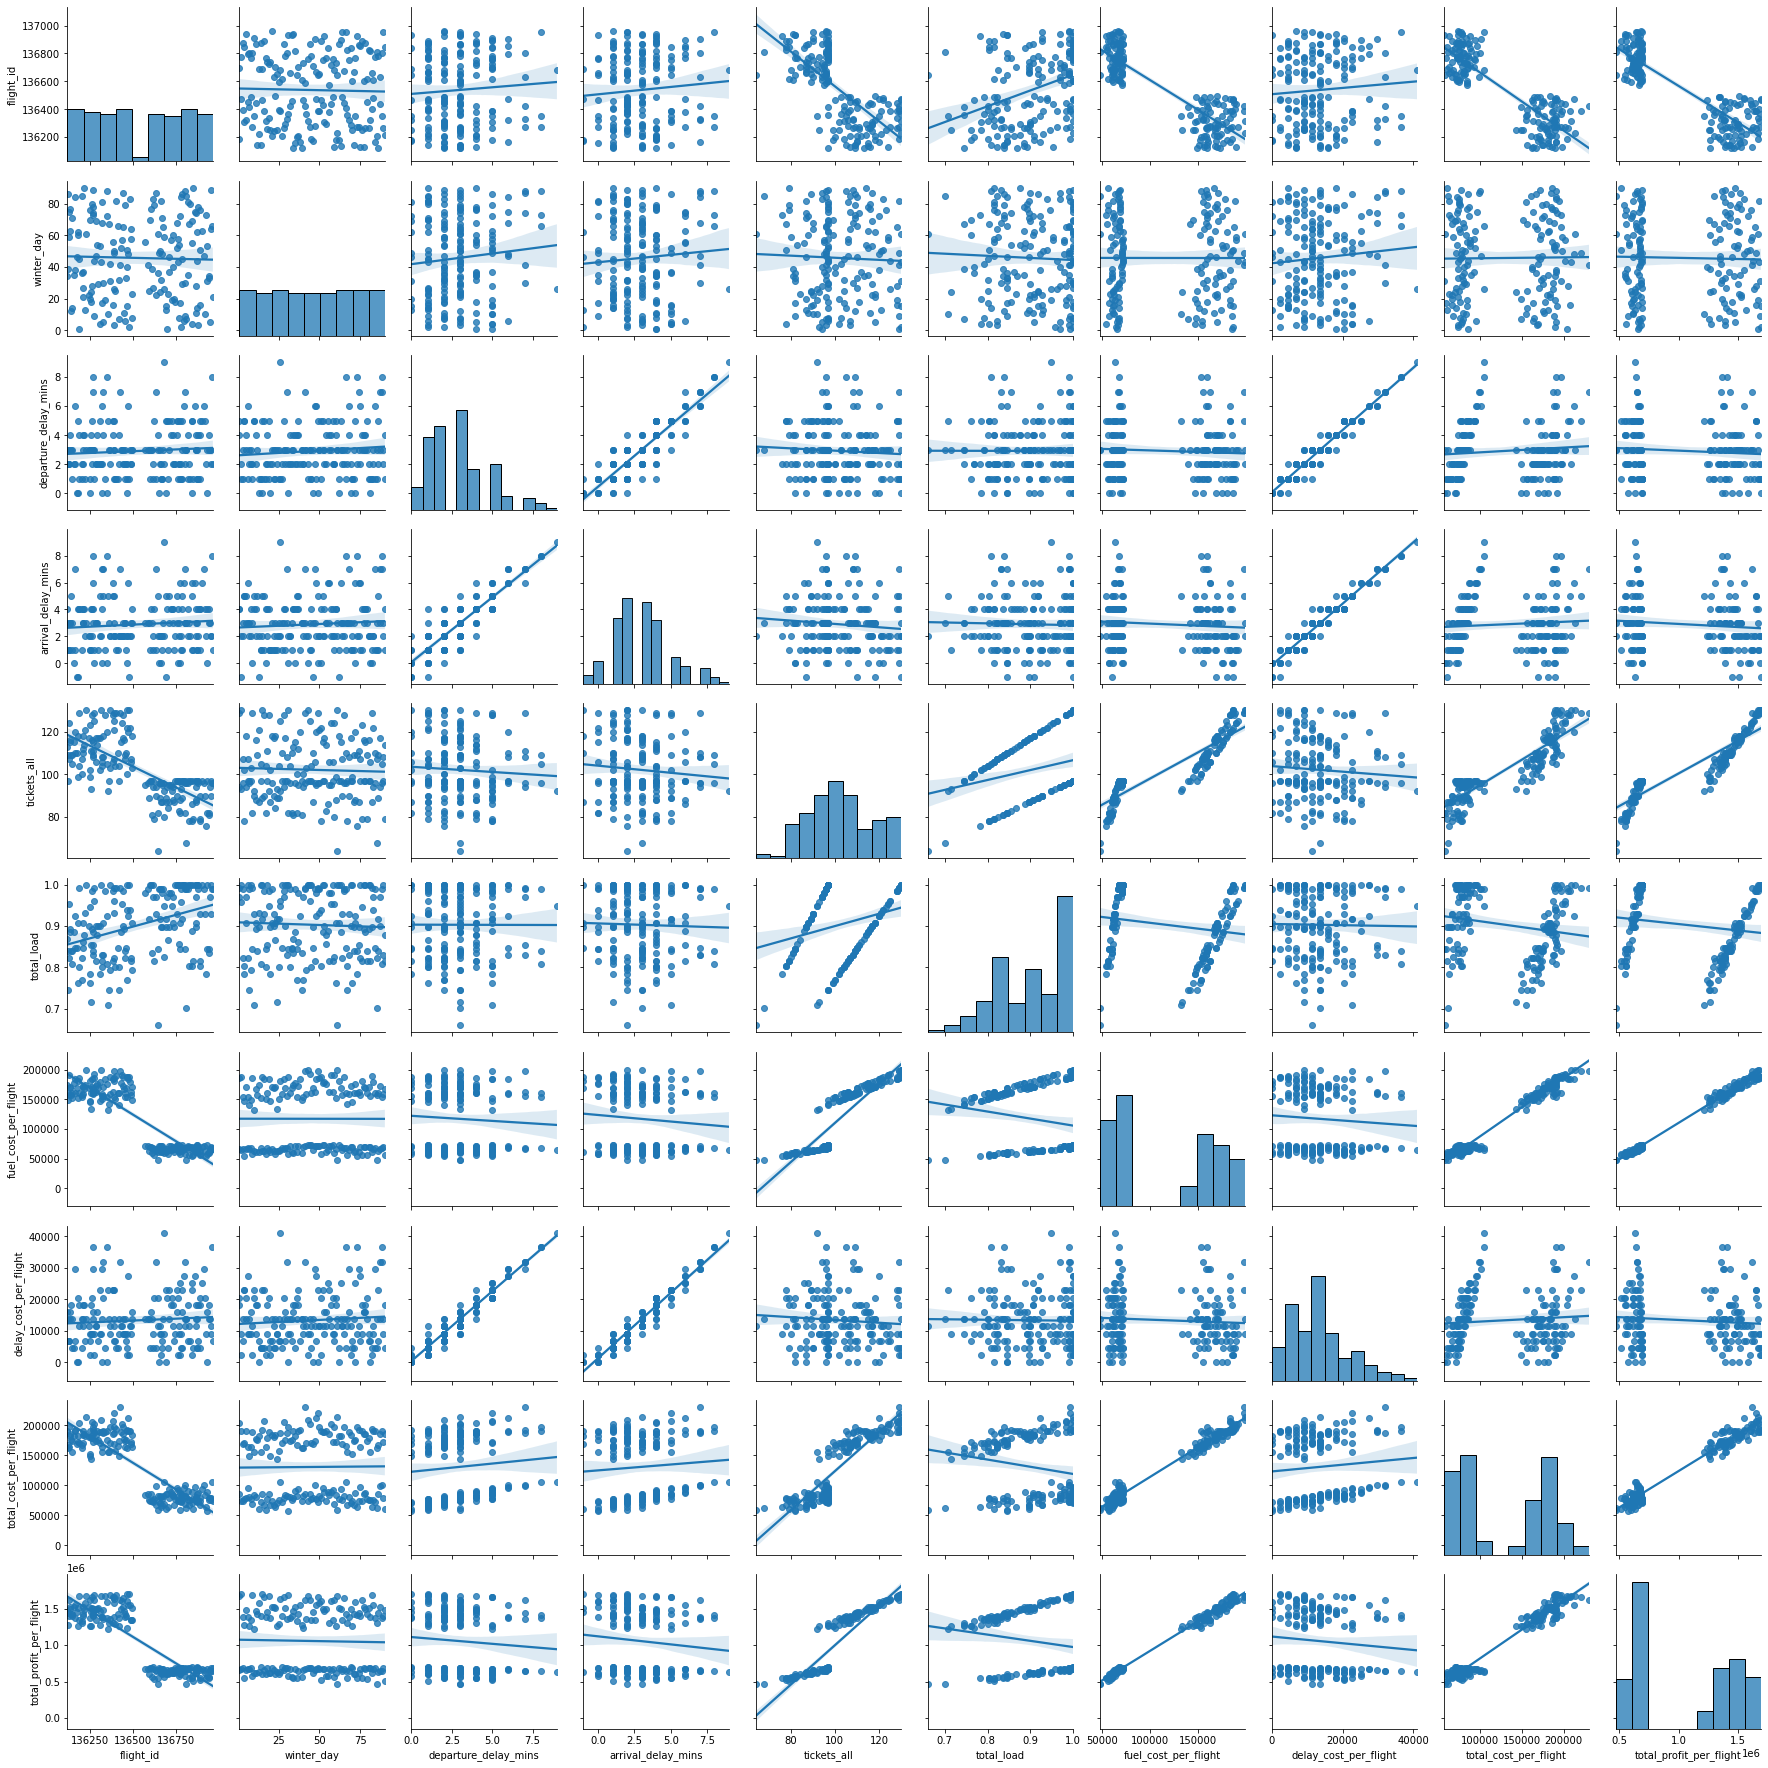

In [59]:
sns.pairplot(dataset, kind='reg')

## 14. Сравнения за один рейс по маркам самолётов 

### 14.1 Прибыль

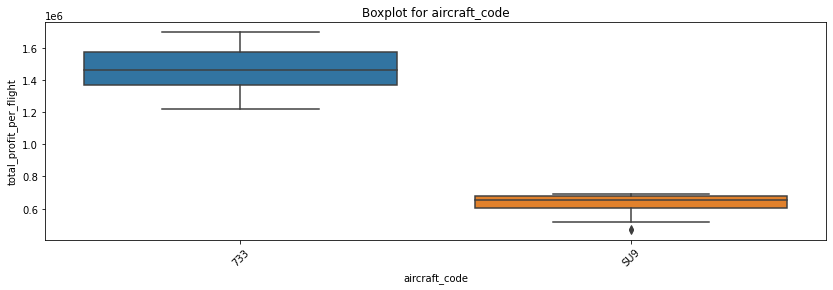

In [60]:
get_boxplot(dataset, "aircraft_code", dataset.total_profit_per_flight)

### 14.2 Затраты

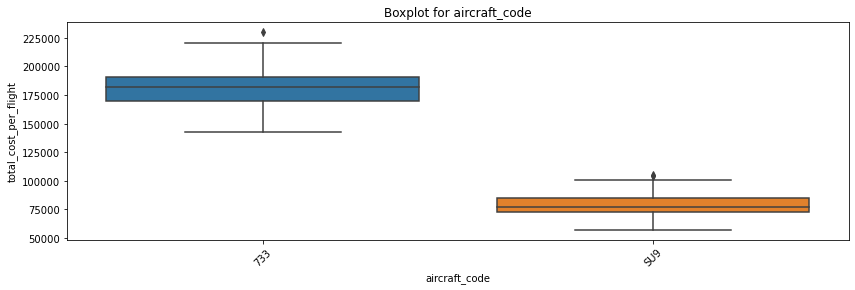

In [61]:
get_boxplot(dataset, "aircraft_code", dataset.total_cost_per_flight)

### 14.3 Загруженность в долях

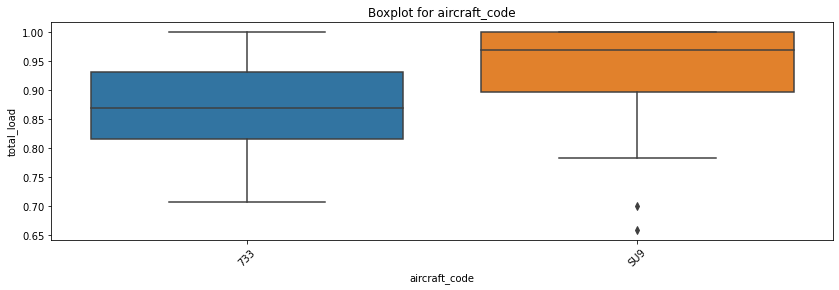

In [62]:
get_boxplot(dataset, "aircraft_code", dataset.total_load)

### 14.4 Задержки

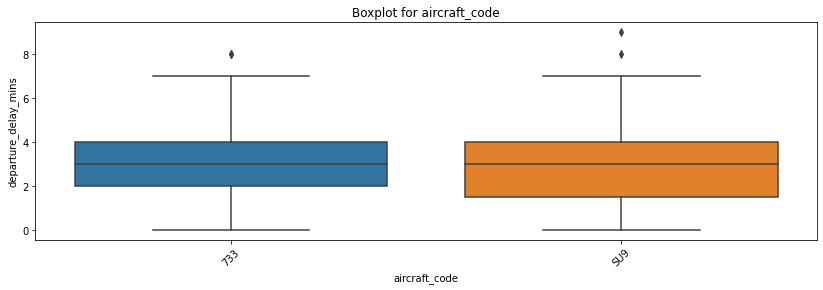

In [63]:
get_boxplot(dataset, "aircraft_code", dataset.departure_delay_mins)

### 14.5 Опоздания

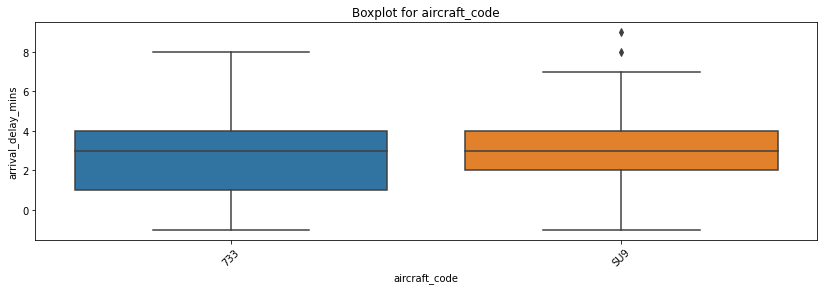

In [64]:
get_boxplot(dataset, "aircraft_code", dataset.arrival_delay_mins)

## 15. Сравнения по временной оси

### 15.1 По месяцам

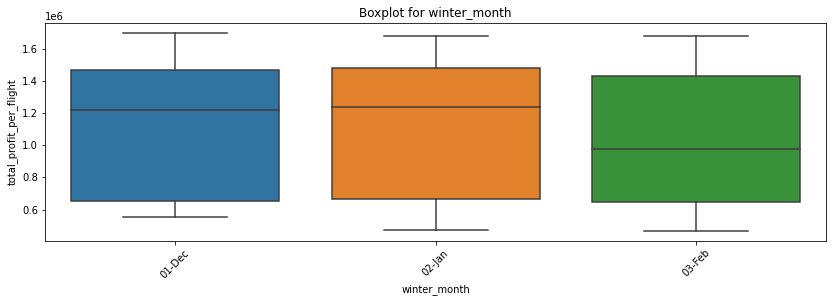

In [65]:
get_boxplot(dataset, "winter_month", dataset.total_profit_per_flight)

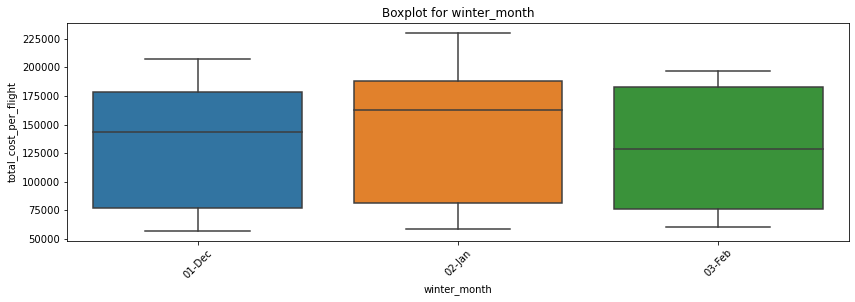

In [66]:
get_boxplot(dataset, "winter_month", dataset.total_cost_per_flight)

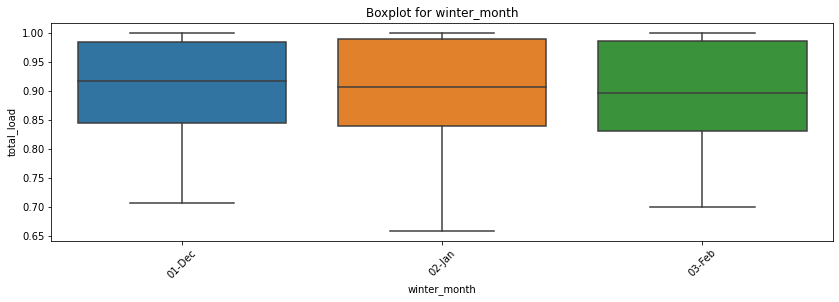

In [67]:
get_boxplot(dataset, "winter_month", dataset.total_load)

#### 15.1.1 По месяцам и самолётам

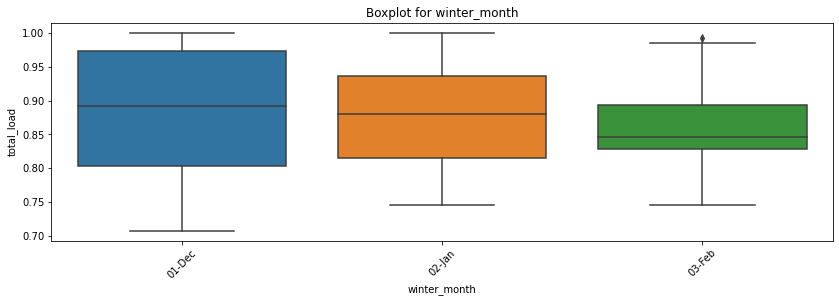

In [68]:
get_boxplot(dataset[dataset.aircraft_code == "733"], "winter_month", dataset.total_load)

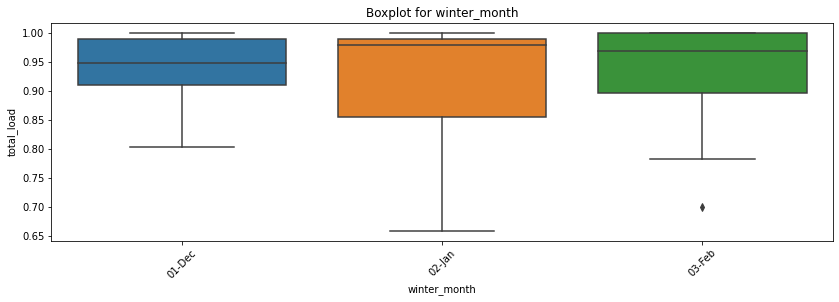

In [69]:
get_boxplot(dataset[dataset.aircraft_code == "SU9"], "winter_month", dataset.total_load)

### 15.2 По дням в зимнее время года

<AxesSubplot:xlabel='winter_day', ylabel='total_cost_per_flight'>

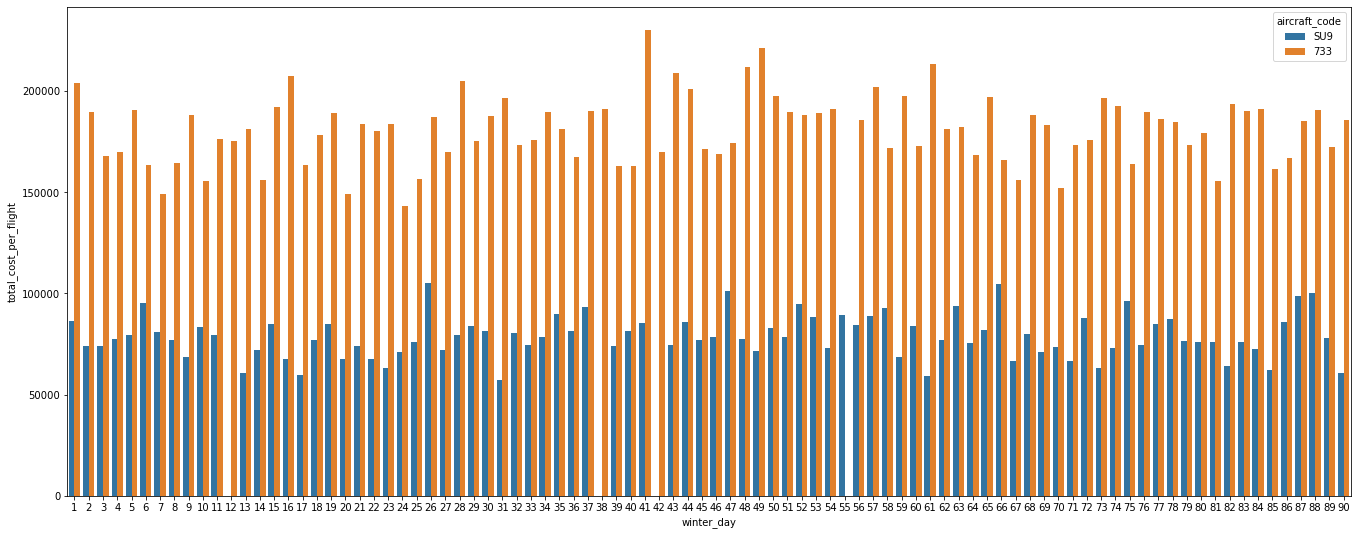

In [70]:
plt_dims = (23, 9)
fig, ax = plt.subplots(figsize=plt_dims)
sns.barplot(x="winter_day", y="total_cost_per_flight", hue="aircraft_code", data=dataset, ax=ax)

## 16. Общие выводы

Из графиков и матрицы коэффициентов корреляции можно сделать ряд предварительных выводов
- Время задержек рейсов время опозданий слабо положительно коррелирует с порядковым номером дня в зимнее время года. То есть чем ближе к концу зимы, тем расходы на задержки рейсов могут быть выше;
- Медианное значение прибыли ниже в феврале, в соответствии с 1-й диаграммой в пункте 15.1;
- Медианное значение относительной загруженности рейса также ниже всего в феврале по 3-й диаграмме пункта 15.1. При этом По первой диаграмме пункта 15.1.1 видно, что снижение загруженности рейса по месяцам спадпет для самолёта Boeing 737-300, а для SSJ-100 меняется мало.
- Из диаграммы в пункте 14.1 видно, что Boeing 737-300 приносим прибыли за рейс намного больше, чем SSJ-100, но при этом по диаграмме загруженности из пункта 14.3 видно, что Boeing 737-300 в среднем загружен меньше, чем SSJ-100. то есть самолёты типа Boeing 737-300 можно было бы использовать более эффективно, если перенести на 737-300 пассажиров с рейсов, где сейчас летает SSJ-100.

<b>Общая рекомендация:</b> перенести пассажирские авиаперевозки с самолётов типа SSJ-100 на самолёты типа Boeing 737-300, чтобы более эффективно использовать более прибыльный самолёт; оптимизировать (уменьшить) колическтво рейсов в феврале месяце так, чтобы повысить загруженность самолётов и эффективно уменьшить расходы на задержки рейсов в аэропортах к концу зимнего периода.

In [71]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 13 to 192
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   flight_id                176 non-null    float64       
 1   departure_airport        176 non-null    object        
 2   arrival_airport          176 non-null    object        
 3   winter_day               176 non-null    int64         
 4   winter_month             176 non-null    object        
 5   actual_departure         176 non-null    datetime64[ns]
 6   actual_arrival           176 non-null    datetime64[ns]
 7   departure_delay_mins     176 non-null    float64       
 8   arrival_delay_mins       176 non-null    float64       
 9   tickets_all              176 non-null    float64       
 10  total_load               176 non-null    float64       
 11  fuel_cost_per_flight     176 non-null    float64       
 12  delay_cost_per_flight    176 non-nu

In [72]:
dataset.to_csv("final_dataset_2016_2017.csv", index=False)